In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import networkx as nx
import music21 as msc
from funciones import *
import sys
import os
from music21 import corpus
from scipy import optimize

In [18]:
musicos_1 = ['bach']
#creo una lista que contenga los grafos con cada artista, va a ser una ls de ls de 5 elemen: [[M,A,R,D,U]]
H = [] # Lista para los clasicos
K = [] # Lista para los populares
G = [] # Lista completa de cada artista + 5 grafos (melodia, absoluta (dist a tonica), ritmo, arm dirigida, arm no dirigida)

for l, musico in enumerate(musicos_1):
    # Para cada musico clasico, agrega a la lista H los 4 grafos completos de cada obra
    m = nx.DiGraph()
    a = nx.DiGraph()
    r = nx.DiGraph()
    ad= nx.MultiDiGraph()
    au= nx.MultiGraph()
    paths = corpus.getComposer(musico)
    paths = paths[0:20] #corta hasta los primeros 20 temas
    for i, path in enumerate(paths):
        # Crea los cuatro grafos para cada cancion y los agrega a H como un único elemento
        M1,A1,R1,D1,U1 = f_full_graph(path,voz_principal=True)
        H.append([M1,A1,R1,D1,U1])
        
    for l in range(len(H)):
        # Recorre cada elemento de H (listas de cuatro grafos) y une los correspondientes
        m = f_compose(m,H[l][0])
        a = f_compose(a,H[l][1])
        r = f_compose(r,H[l][2])
        #ad= f_compose(ad,H[l][3],'AD')
        #au= f_compose(au,H[l][4],'AU')
    G.append([musico,m,a,r,ad,au])
    # Agrega a G la lista de artista + 4 grafos completos por artista


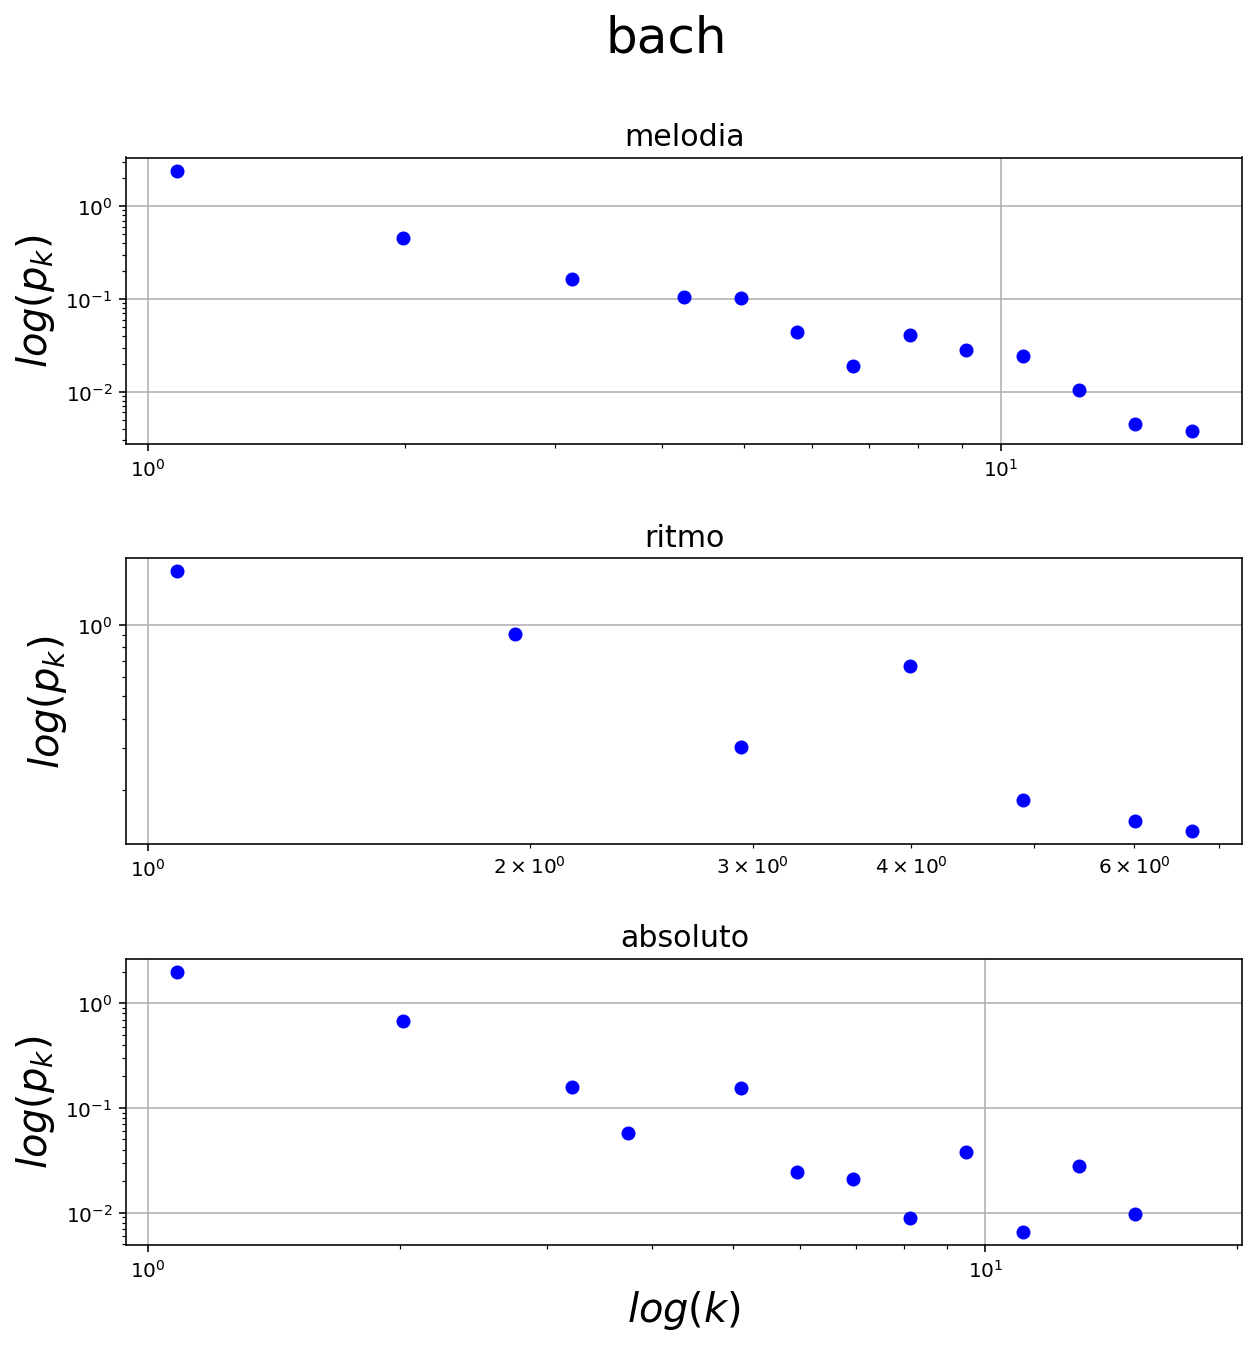

In [4]:
plt.figure(figsize=(10,10))
plt.suptitle(musico,fontsize=25)

plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.4)
plt.title('melodia',fontsize=15)
f_grado_dist(G[0][1],'directed')
plt.xlabel('')

plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=0.4)
f_grado_dist(G[0][3],'directed')
plt.title('ritmo',fontsize=15)
plt.xlabel('')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=0.4)
plt.title('absoluto',fontsize=15)
f_grado_dist(G[0][2],'directed')

ValueError: operands could not be broadcast together with shapes (19,) (0,) 

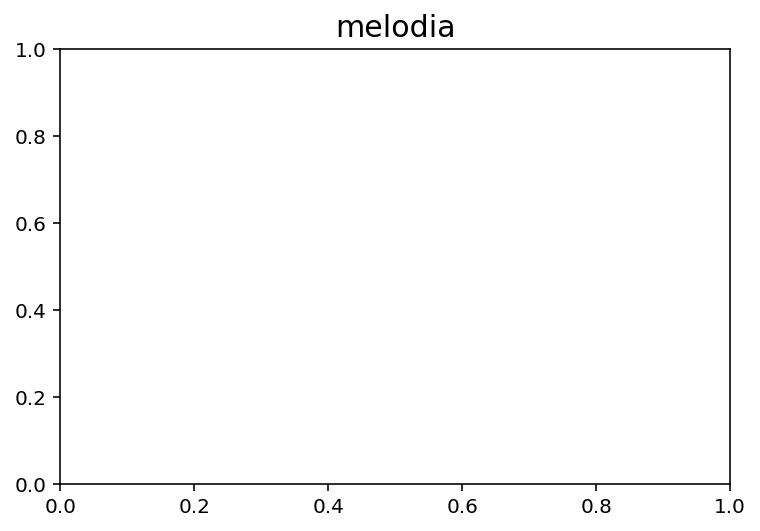

In [46]:
plt.title('melodia',fontsize=15)
x,y=f_grado_dist(G[0][1],'directed')
type(x)
f_fiteo(x,y,0)
plt.xlabel('')

In [45]:
def f_fiteo(xdata,ydata,yerr): #x, y e yerr ya tienen que estar en base log

    logx = xdata
    logy = ydata
    logyerr = yerr

    type(logyerr)
    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    pinit = [1, -1]
    out = optimize.leastsq(errfunc, pinit,args=(logx, logy, logyerr), full_output=1)

    pfinal = out[0]
    covar = out[1]
    print(pfinal)
    print(covar)

    index = pfinal[1]
    amp = 10.0**pfinal[0]

    indexErr = np.sqrt( covar[1][1] )
    ampErr = np.sqrt( covar[0][0] ) * amp

    ##########
    # Plotting data
    ##########

    plt.clf()

    plt.loglog(xdata, powerlaw(xdata, amp, index))
    plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
    plt.text(5, 6.5, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
    plt.text(5, 5.5, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
    plt.xlabel('log(k)')
    plt.ylabel('log(p_{k})')
    plt.xlim(1.0, 11)
    
    return()

In [28]:
def f_grado_dist(G,modelo): #el grafo puede ser dirigido o no dirigido
    
    H=G.copy()
    nodos=H.nodes() 
    N=len(nodos)

    if modelo == 'undirected':
        
        #calculo los grados que salen y entran de cada nodo
        kgrados = [H.degree(nodo) for nodo in nodos]
    
        # Contamos la cantidad de nodos que tienen un cierto k_grado, usando la funcion np.unique()
        # Guardamos el resultado en la variable histograma
        histograma = np.unique(kgrados,return_counts=True)
        k = histograma[0] # grados
        pk = histograma[1]/float(N) # pk = Nk/N, donde N es el numero total de nodos (cuentas normalizadas)
        maxgrado = max(k) #maximo grado

        logbin = np.logspace(0,np.log10(maxgrado),num=20,endpoint=True,base=10) # bineado en base 10
        histograma_logbin = np.histogram(kgrados,bins=logbin,density=False)

        # Normalizamos por el ancho de los bines y creamos el vector bin_centros
        bin_centros = []
        pk_logbin = []

        for i in range(len(logbin)-1):
            bin_centros.append((logbin[i+1]+logbin[i])/2)
            bin_ancho = logbin[i+1]-logbin[i]
            pk_logbin.append(histograma_logbin[0][i]/(bin_ancho*N)) #normalizamos por el ancho del bin y por el numero total de nodos
        
        #plt.plot(bin_centros,pk_logbin,'bo')
        #plt.xlabel('$log(k)$',fontsize=20)
        #plt.xscale('log')
        #plt.ylabel('$log(p_{k})$',fontsize=20)
        #plt.yscale('log')
        #plt.title('Bin log - Escala log',fontsize=20)
        
        return(bin_centros_in,pk_logbin)

    
    elif modelo == 'directed':
        #calculo los grados que salen y entran de cada nodo
        kgrados_out = [H.out_degree(nodo) for nodo in nodos]
        kgrados_in = [H.in_degree(nodo) for nodo in nodos]

        # Contamos la cantidad de nodos que tienen un cierto k_grado, usando la funcion np.unique()
        # Guardamos el resultado en la variable histograma
        histograma_out = np.unique(kgrados_out,return_counts=True)
        k_out = histograma_out[0] # grados
        pk_out = histograma_out[1]/float(N) # pk = Nk/N, donde N es el numero total de nodos (cuentas normalizadas)
        maxgrado_out = max(k_out) #maximo grado

        logbin_out = np.logspace(0,np.log10(maxgrado_out),num=20,endpoint=True,base=10) # bineado en base 10
        histograma_logbin_out = np.histogram(kgrados_out,bins=logbin_out,density=False)

        # Normalizamos por el ancho de los bines y creamos el vector bin_centros
        bin_centros_out = []
        pk_logbin_out = []
        for i in range(len(logbin_out)-1):
            bin_centros_out.append((logbin_out[i+1]+logbin_out[i])/2)
            bin_ancho = logbin_out[i+1]-logbin_out[i]
            pk_logbin_out.append(histograma_logbin_out[0][i]/(bin_ancho*N)) #normalizamos por el ancho del bin y por el numero total de nodos
        #idem in
        histograma_in = np.unique(kgrados_in,return_counts=True)
        k_in = histograma_in[0] # grados
        pk_in = histograma_in[1]/float(N) # pk = Nk/N, donde N es el numero total de nodos (cuentas normalizadas)
        maxgrado_in = max(k_in) #maximo grado

        logbin_in = np.logspace(0,np.log10(maxgrado_in),num=20,endpoint=True,base=10) # bineado en base 10
        histograma_logbin_in = np.histogram(kgrados_in,bins=logbin_in,density=False)

        # Normalizamos por el ancho de los bines y creamos el vector bin_centros
        bin_centros_in = []
        pk_logbin_in = []
        for i in range(len(logbin_in)-1):
            bin_centros_in.append((logbin_in[i+1]+logbin_in[i])/2)
            bin_ancho = logbin_in[i+1]-logbin_in[i]
            pk_logbin_in.append(histograma_logbin_in[0][i]/(bin_ancho*N)) #normalizamos por el ancho del bin y por el numero total de nodos
    
        
        # Escala logaritmica en ambos ejes
        #plt.figure()
        #plt.suptitle('Bin log - Escala log',fontsize=25)

        #plt.subplot(1, 2, 1)
        #plt.plot(bin_centros_out,pk_logbin_out,'bo')
        #plt.xscale('log')
        #plt.yscale('log')
        #plt.xlabel('$log (k)$',fontsize=20)
        #ay = plt.gca()
        #ay.grid(True)
        #plt.ylabel('$log (p_{k})$',fontsize=20)
        #plt.title('Enlaces salientes',fontsize=20)

        #plt.subplot(1, 2, 2)
        #plt.plot(bin_centros_in,pk_logbin_in,'bo')
        #plt.xscale('log')
        #plt.yscale('log')
        #ay = plt.gca()
        #ay.grid(True)
        #plt.xlabel('$log (k)$', fontsize=20)
        #plt.ylabel('$log (p_{k})$', fontsize=20)
        #plt.title('Enlaces entrantes',fontsize=20)
        
        return(bin_centros_in,pk_logbin_in)


In [29]:
def f_hierarchy(G): #grafica Ck vs K en log, y a partir de eso uno ve si es una red jerárquica
    
    H=G.copy()
    #H = H.to_undirected()
    nodos=H.nodes() 
    grados=[]
    Cs=[]
    Cs_prom=[]
    Cs_error=[]
    cs_err=[]

    
    for i,nodo in enumerate(nodos):
        grados.append(H.degree(nodo))
        Cs.append(nx.clustering(H, nodo)) #sin pesos

    #Busco los Cs que tengan el mismo grado y los promedio    
    for i,k in enumerate(grados):
        ls=[]
        for j, c in enumerate(Cs):
            if k == grados[j]:
                ls.append(Cs[j])
        Cs_prom.append(np.mean(ls))
        Cs_error.append(np.std(ls))
        
        cs_err.append((1/np.log(10))*(1/Cs_prom[i])*Cs_error[i])
    
    
    #plt.figure(figsize=(9,9))
    #plt.plot(grados,Cs_prom,'bo')
    #plt.errorbar(grados, Cs_prom, xerr=None, yerr=cs_err, fmt=' ',ecolor='green',elinewidth=5,capsize=5,markersize=3)
    #plt.xscale('log')
    #plt.yscale('log')
    
    #plt.xlabel('$k$')
    #plt.ylabel('$C(k)$')
    #plt.title('Bin lineal - Escala log')
    #plt.show()
    
    return(grados,Cs_prom, cs_err)